# Chinese glyph explorer
Related blog post [here](https://yue-here.github.io/glyphexplorer/)

## UMAP of raw images
Run UMAP dimensional reduction on the raw data to visualise clustering

In [17]:
import os
import numpy as np
from PIL import Image
from sklearn.preprocessing import StandardScaler
import umap
import plotly.express as px

# Function to convert Unicode to the corresponding character
def unicode_to_character(unicode_str):
    return chr(int(unicode_str, 16))

# Step A: Load images and prepare hover text
def load_images_and_labels(folder_path, size=(64, 64)):
    images = []
    hover_text = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.png'):
            unicode_str = filename.split('.')[0]  # Assuming filename format is 'UNICODE.png'
            character = unicode_to_character(unicode_str)
            hover_text.append(character)
            
            img_path = os.path.join(folder_path, filename)
            with Image.open(img_path) as img:
                img = img.convert('L')  # Convert to grayscale
                img = img.resize(size)  # Resize image
                images.append(np.array(img).flatten())
    return np.array(images), hover_text

# Step B: UMAP reduction
def run_umap(data, n_components=2, n_neighbors=15, min_dist=0.1):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)
    reducer = umap.UMAP(n_components=n_components, n_neighbors=n_neighbors, min_dist=min_dist)
    embedding = reducer.fit_transform(scaled_data)
    return embedding

# folder_path = 'data'  # Update this path
# images, hover_text = load_images_and_labels(folder_path)
# embedding = run_umap(images)

c:\Users\y_w_u\miniconda3\envs\torchcuda12\Lib\site-packages\tqdm\auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



In [13]:
# Visualizing with plotly and save as JSON to embed in blog
# Embed using method in https://ig248.gitlab.io/post/2018-11-05-plotly-sample/

def plot_embedding(
        embedding, 
        hover_text, 
        filename,
        write_path='data'
        ):
    fig = px.scatter(
        x=embedding[:, 0], 
        y=embedding[:, 1],
        custom_data=[hover_text],
        labels={'x': 'UMAP 1', 'y': 'UMAP 2'}, 
        # title=title, 
        # width=800, 
        # height=800
    )
    
    # Update hover template to only show hover_text with custom font
    fig.update_traces(
        marker=dict(size=3, opacity=0.2),
        hovertemplate='<b>%{customdata[0]}</b><extra></extra>',  # Hide extra data with <extra></extra>
        hoverlabel=dict(
            font=dict(
                family="Noto Sans SC, sans-serif",  # Choose your preferred font family
                size=128,                     # Set the font size
            )
        )
    )
    
    # Adjusting the plot to be square
    fig.update_layout(
        xaxis=dict(constrain='domain'),
        yaxis=dict(scaleanchor='x', scaleratio=1)
    )

    fig.write_json(os.path.join(write_path, f"{filename}.json"))
    
    # Display the plot
    fig.show()

In [3]:
plot_embedding(embedding, hover_text)

## Train a variational autoencoder (VAE)

In [1]:
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import numpy as np
import cv2
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the VAE architecture
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # Encoder
        self.conv1 = nn.Conv2d(1, 32, 4, stride=2, padding=1) # Output size: [32, 64, 64]
        self.conv2 = nn.Conv2d(32, 64, 4, stride=2, padding=1) # Output size: [64, 32, 32]
        self.conv3 = nn.Conv2d(64, 128, 4, stride=2, padding=1) # Output size: [128, 16, 16]
        self.conv4 = nn.Conv2d(128, 256, 4, stride=2, padding=1) # Output size: [256, 8, 8]
        self.conv5 = nn.Conv2d(256, 512, 4, stride=2, padding=1) # Output size: [512, 4, 4]
        
        # Latent vectors mu and logvar
        self.fc1 = nn.Linear(512*4*4, 1024)
        self.fc_mu = nn.Linear(1024, 256)
        self.fc_logvar = nn.Linear(1024, 256)

        # Decoder
        self.fc2 = nn.Linear(256, 512*4*4)
        self.conv6 = nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1)
        self.conv7 = nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1)
        self.conv8 = nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1)
        self.conv9 = nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1)
        self.conv10 = nn.ConvTranspose2d(32, 1, 4, stride=2, padding=1)

    def encode(self, x):
        h = F.relu(self.conv1(x))
        h = F.relu(self.conv2(h))
        h = F.relu(self.conv3(h))
        h = F.relu(self.conv4(h))
        h = F.relu(self.conv5(h))
        h = h.view(-1, 512*4*4)
        h = F.relu(self.fc1(h))
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h = F.relu(self.fc2(z))
        h = h.view(-1, 512, 4, 4)
        h = F.relu(self.conv6(h))
        h = F.relu(self.conv7(h))
        h = F.relu(self.conv8(h))
        h = F.relu(self.conv9(h))
        return torch.sigmoid(self.conv10(h))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD


### Initialize dataloaders and model

In [2]:
# Initialize model
model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Initialize dataloader
class ChineseCharacterDataset(Dataset):
    def __init__(self, folder_path):
        self.folder_path = folder_path
        # self.file_names = os.listdir(folder_path)
        self.file_names = [file for file in os.listdir(folder_path) if file.endswith(('.png'))]
        self.transform = transforms.Compose([
            transforms.Grayscale(),  # Convert to monochrome
            transforms.Resize((128, 128)),
            transforms.ToTensor(),
            # transforms.Normalize(mean=[0.5], std=[0.5])
        ])

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        img_name = os.path.join(self.folder_path, self.file_names[idx])
        image = Image.open(img_name)
        image = self.transform(image)
        return image

dataset = ChineseCharacterDataset('data')
# data_loader = DataLoader(dataset, batch_size=256, shuffle=True)

# Train-test split
total_size = len(dataset)
train_size = int(0.8 * total_size)  # 80% of the dataset for training
test_size = total_size - train_size  # Remaining 20% for testing

# Split the dataset
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create data loaders for train and test sets
batch_size = 512*4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)\
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

Epoch 0, Training Loss: 8478.631035790113, Test Loss: 5511.863017800825
Epoch 1, Training Loss: 5395.294513952078, Test Loss: 5350.816002547307
Epoch 2, Training Loss: 5341.724806642402, Test Loss: 5332.612312742601
Epoch 3, Training Loss: 5327.132525781013, Test Loss: 5321.947753669336
Epoch 4, Training Loss: 5317.28732559903, Test Loss: 5309.328227347161
Epoch 5, Training Loss: 5306.20054974219, Test Loss: 5299.589997270742
Epoch 6, Training Loss: 5282.22745677889, Test Loss: 5267.655552523047
Epoch 7, Training Loss: 5239.569887397634, Test Loss: 5269.530040787239
Epoch 8, Training Loss: 5198.820501592357, Test Loss: 5141.70244268559
Epoch 9, Training Loss: 5090.725053078556, Test Loss: 5066.476782356865
Epoch 10, Training Loss: 4995.8575219896875, Test Loss: 4989.981253411572
Epoch 11, Training Loss: 4873.109588262057, Test Loss: 4799.825613703906
Epoch 12, Training Loss: 4721.324370639975, Test Loss: 4701.527794835638
Epoch 13, Training Loss: 4593.453021686381, Test Loss: 4566.0572

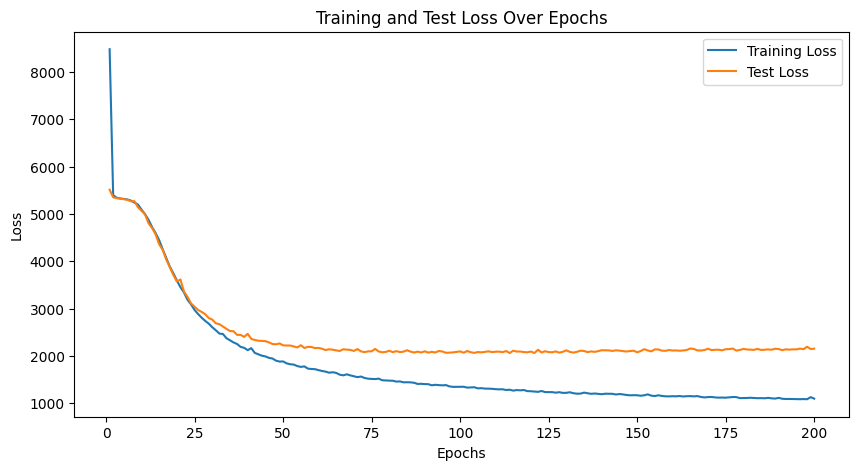

In [3]:
# Create 'saved_models' directory if it doesn't exist
saved_models_dir = 'saved_vae'
if not os.path.exists(saved_models_dir):
    os.makedirs(saved_models_dir)

# Initialize loss tracking
train_losses = []
test_losses = []

# Set the number of epochs
num_epochs = 200  # Example, set this as needed

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    # Calculate average training loss
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation (test) phase
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            recon, mu, logvar = model(data)
            test_loss += loss_function(recon, data, mu, logvar).item()
    
    # Calculate average test loss
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print(f"Epoch {epoch}, Training Loss: {train_loss}, Test Loss: {test_loss}")

    # Save the model every 10 epochs
    if (epoch + 1) % 10 == 0:
        save_path = os.path.join(saved_models_dir, f'model_epoch_{epoch+1}.pth')
        torch.save(model.state_dict(), save_path)

# Plotting the training and test loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss Over Epochs')
plt.legend()
plt.show()

In [3]:
def show_reconstructions(model, data_loader, num_images=6):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # No need to track gradients
        # Get a batch of images
        for batch in data_loader:
            batch = batch.to(device)
            recon, _, _ = model(batch)
            break  # We only need one batch

    batch = batch.cpu()
    recon = recon.cpu()

    fig, axs = plt.subplots(2, num_images, figsize=(15, 4))
    for i in range(num_images):
        # Display original images
        axs[0, i].imshow(batch[i].reshape(128, 128), cmap='gray')
        axs[0, i].set_title(f"Original {i+1}")
        axs[0, i].axis('off')

        # Display reconstructed images
        axs[1, i].imshow(recon[i].reshape(128, 128), cmap='gray')
        axs[1, i].set_title(f"Reconstructed {i+1}")
        axs[1, i].axis('off')

    plt.show()

# Assuming you already have your model and data_loader
# show_reconstructions(model, test_loader, num_images=6)

Loading model on: cuda


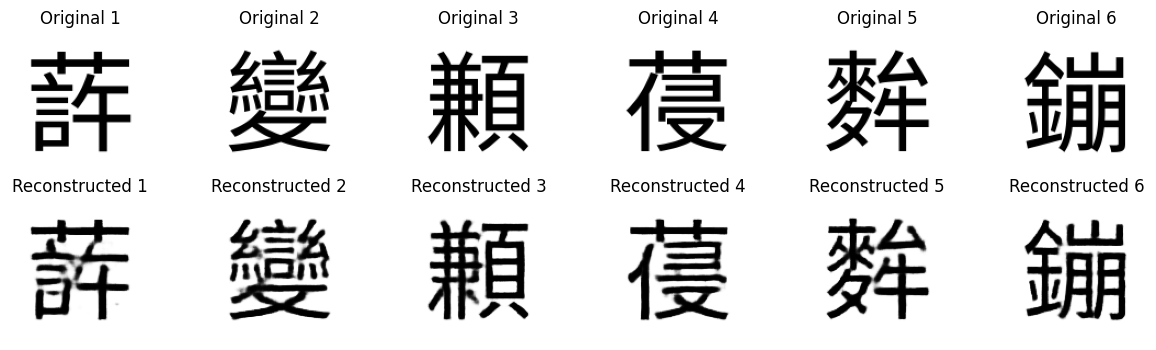

In [23]:
def load_model(model_path, model_architecture):
    if not os.path.isfile(model_path):
        print(f"Model file not found: {model_path}")
        return None

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Loading model on: {device}")

    model = model_architecture().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    return model

# Load model
model_path = './saved_vae/model_epoch_200.pth'
loaded_model = load_model(model_path, VAE)

# Show reconstructions
show_reconstructions(loaded_model, test_loader, num_images=6)

## Visualize the latent space

Generarate latent vectors for dataset using the VAE encoder

In [16]:
# Example usage
model_path = './saved_vae/model_epoch_200.pth'
model = load_model(model_path, VAE)
model.eval()  # Set the model to evaluation mode
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')  # Move model to appropriate device

dataset = ChineseCharacterDataset('data')
data_loader = DataLoader(dataset, batch_size=512, shuffle=False)

latent_vectors = []
with torch.no_grad():  # No need to compute gradients
    for batch in data_loader:
        inputs = batch.to(device)
        mu, _ = model.encode(inputs)
        latent_vectors.append(mu)

latent_vectors = torch.cat(latent_vectors).cpu().numpy()

Loading model on: cuda


Run the UMAP routine again on the latent vectors

In [22]:
# Print the shape of the latent vectors
print(latent_vectors.shape)

(20607, 256)


In [19]:
embedding = run_umap(latent_vectors)

np.save('latent_vectors.npy', latent_vectors)
np.save('embedding.npy', embedding)

In [21]:
plot_embedding(
    embedding, 
    hover_text,
    filename='umap_vae',
    write_path=r"C:\Users\y_w_u\OneDrive\hugo\sites\ghpage\static")

## Walk through latent space

In [24]:
def interpolate_latent_space(vae, start_vector, end_vector, steps):
    interpolated_vectors = []
    for alpha in np.linspace(0, 1, steps):
        # Linear interpolation
        interp_vector = start_vector * (1 - alpha) + end_vector * alpha
        interpolated_vectors.append(interp_vector)
    return interpolated_vectors

def decode_vectors_to_images(vae, latent_vectors):
    images = []
    with torch.no_grad():
        for i, vector in enumerate(latent_vectors):
            image = vae.decode(vector).cpu()
            # Ensure the output is (C, H, W), then convert to (H, W, C)
            image = image.squeeze(0).permute(1, 2, 0).numpy()
            # Ensure pixel values are in the range [0, 255]
            # image = ((image + 1) * 127.5).astype(np.uint8)
            image = (image * 255).astype(np.uint8)
            images.append(image)
    return images

def create_video(images, video_path, fps=60, scale_factor=4):
    if len(images) == 0:
        print("No images provided to create video.")
        return

    # Original dimensions
    original_height, original_width = images[0].shape[:2]

    # Scaled dimensions
    width, height = int(original_width * scale_factor), int(original_height * scale_factor)

    # H.264 codec shares best on whatsapp
    video = cv2.VideoWriter(video_path, cv2.VideoWriter_fourcc(*'X264'), fps, (width, height))

    for image in images:
        # Convert from RGB to BGR
        bgr_image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        # Resize the image
        resized_image = cv2.resize(bgr_image, (width, height), interpolation=cv2.INTER_LINEAR)
        video.write(resized_image)
        cv2.imshow("Frame", resized_image)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    video.release()
    cv2.destroyAllWindows()

In [47]:
def get_latent_vectors_for_unicode(vae, unicode_codes, data_folder='./data', image_size=128):
    latent_vectors = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    vae.to(device)  # Move the VAE model to the GPU if available

    transform = transforms.Compose([
        transforms.Grayscale(),  # Convert to monochrome
        # transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.5], std=[0.5])
    ])

    for code in unicode_codes:
        image_path = os.path.join(data_folder, f"{code}.png")
        if not os.path.exists(image_path):
            print(f"Image for Unicode {code} not found.")
            continue

        image = Image.open(image_path)
        image = transform(image).unsqueeze(0).to(device)  # Apply transformations and move to device

        with torch.no_grad():
            vae.eval()
            mu, _ = vae.encode(image)  # Assuming VAE's encode method returns mu and logvar
            latent_vectors.append(mu.squeeze(0)) #.cpu())  # Remove batch dimension and move to CPU

    return latent_vectors

def string_to_unicode_codes(input_string):
    unicode_codes = [format(ord(char), 'x') for char in input_string]
    return unicode_codes

def create_interpolation_video_from_unicode(vae, unicode_codes, data_folder, video_path, steps_per_interpolation=180, fps=60):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    vae.to(device)  # Ensure the VAE model is on the correct device

    # Get latent vectors for the given Unicode codes, also ensure they are on the same device
    latent_vectors = get_latent_vectors_for_unicode(vae, unicode_codes, data_folder)
    latent_vectors = [vec.to(device) for vec in latent_vectors]  # Move all latent vectors to the same device

    all_interpolated_images = []

    for i in range(len(latent_vectors) - 1):
        start_vector = latent_vectors[i].unsqueeze(0)
        end_vector = latent_vectors[i+1].unsqueeze(0)

        interpolated_vectors = interpolate_latent_space(vae, start_vector, end_vector, steps_per_interpolation)
        decoded_images = decode_vectors_to_images(vae, interpolated_vectors)
        all_interpolated_images.extend(decoded_images)

    # Create video from all interpolated images
    create_video(all_interpolated_images, video_path, fps)



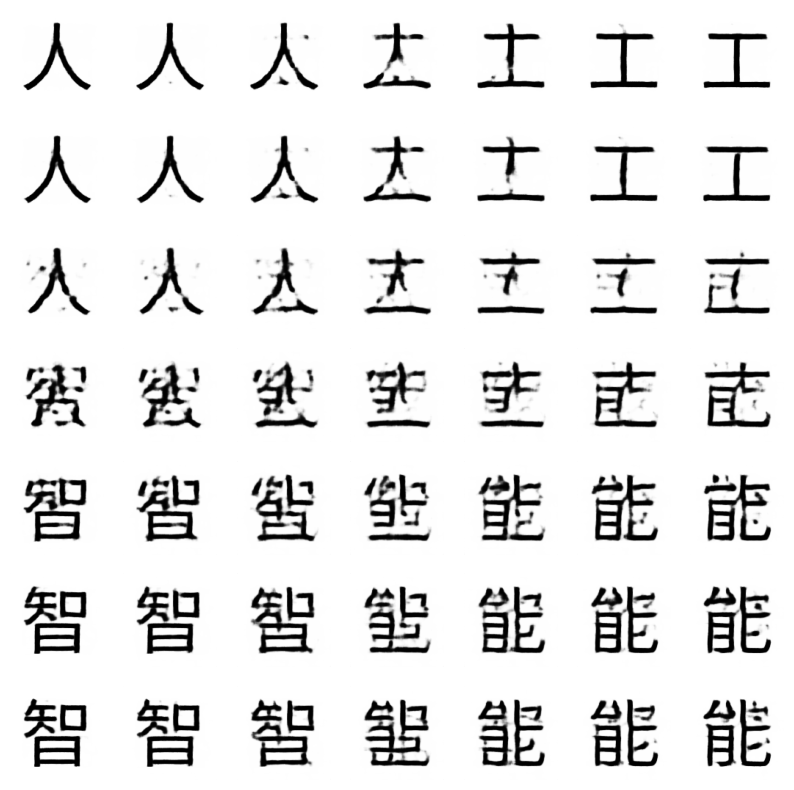

In [56]:
def generate_and_plot_interpolations(vae, chars, data_folder='./data', image_size=128, steps=5):
    # First, get the Unicode codes of the characters
    unicode_codes = string_to_unicode_codes(chars)
    
    # Retrieve the latent vectors for the given Unicode codes
    latent_vectors = get_latent_vectors_for_unicode(vae, unicode_codes, data_folder, image_size)
    
    if len(latent_vectors) < 4:
        print("Could not retrieve all latent vectors. Ensure all images are available.")
        return

    # Perform bilinear interpolation in the latent space
    # Assume chars are provided in the order: top_left, top_right, bottom_left, bottom_right
    interpolated_grid = interpolate_latent_space_2d(vae, *latent_vectors, steps=steps)
    
    # Decode the latent vectors into images
    grid_images = decode_grid_to_images(vae, interpolated_grid)
    
    # Plot the images in a grid
    fig, axs = plt.subplots(steps, steps, figsize=(10, 10))
    for i, row in enumerate(grid_images):
        for j, img in enumerate(row):
            axs[i, j].imshow(img, cmap='gray')
            axs[i, j].axis('off')
    plt.show()

def interpolate_latent_space_2d(vae, top_left, top_right, bottom_left, bottom_right, steps):
    interpolated_grid = []
    for alpha in np.linspace(0, 1, steps):
        top_interp = top_left * (1 - alpha) + top_right * alpha
        bottom_interp = bottom_left * (1 - alpha) + bottom_right * alpha
        row = []
        for beta in np.linspace(0, 1, steps):
            bilinear_interp = top_interp * (1 - beta) + bottom_interp * beta
            row.append(bilinear_interp)
        interpolated_grid.append(row)
    return interpolated_grid

def decode_grid_to_images(vae, interpolated_grid):
    images_grid = []
    with torch.no_grad():
        for row in interpolated_grid:
            images_row = []
            for vector in row:
                image = vae.decode(vector).cpu()
                image = image.squeeze(0).permute(1, 2, 0).numpy()
                image = (image * 255).astype(np.uint8)
                images_row.append(image)
            images_grid.append(images_row)
    return images_grid

# Usage example
characters = ['人', '智', '工', '能']
generate_and_plot_interpolations(model, characters, data_folder='./data', image_size=128, steps=7)


In [60]:
input_string = "人工智能人"
unicode_codes = string_to_unicode_codes(input_string)
create_interpolation_video_from_unicode(model, unicode_codes, './data', './VAE_interpolation.mp4')